## This is my attempt at implementing the RouBl algorithm using layer-wise updates

In [130]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm

In [238]:
class FullCovGaussianLayer(nn.Module):
    """Represents a full covariance Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3):
        super(FullCovGaussianLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_params = input_dim * output_dim + output_dim
        # Prior parameters p(theta)
        prior_std = 0.8 ### we can later add this as a parameter
        mu_prior = torch.zeros(input_dim * output_dim + output_dim) # prior mean for all weights and biases
        cov_chol_prior = torch.eye(input_dim * output_dim + output_dim,input_dim * output_dim + output_dim) * prior_std

        self.register_buffer('prior_mean', mu_prior)
        self.register_buffer('prior_weight_cov_chol', cov_chol_prior)
        self.register_buffer('prior_cov_inv', (cov_chol_prior @ cov_chol_prior.t()))

        # initialise the trainable variational parameters for q distribution, setting them equal to the prior
        self.mean = mu_prior
        self.cov_chol = cov_chol_prior

        # initialise lambda (not sure where this is used)
        cov_chol_inv = torch.linalg.inv(self.cov_chol)
        self.lambda_1 = cov_chol_inv @ cov_chol_inv.t() @ self.mean


        # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl
    
    ## Maybe this instead wants to be in the network class and get passed to forward for each layer...might be neater
    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        """Propagates x through this layer by sampling weights from the posterior"""
        # assert (len(input.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        # assert input.shape[-1] == self.input_dim

        # num_samples = x.shape[0]

        weights = sampled_params[:self.input_dim * self.output_dim].view(self.output_dim, self.input_dim)
        biases = sampled_params[self.input_dim * self.output_dim:]

        return F.linear(input, weights, biases)
        # # rsample carries out reparameterisation trick for us   
        # weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        # biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # return x @ weights + biases # (num_samples, batch_size, output_dim).


In [239]:
class FullCovBNN(nn.Module):
    """BNN with layer-wise block diagonal covariance Gaussian distributions."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.LeakyReLU(negative_slope=0.1),
        noise_std=1.0,
    ):
        super(FullCovBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
    
        self.network = nn.ModuleList()

        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(FullCovGaussianLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    FullCovGaussianLayer(self.hidden_dims[i - 1], self.output_dim)
                )
            else:
                self.network.append(
                    FullCovGaussianLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation)
    
    def sample_network_params(self):
        """
        Sample parameters for each layer and store them in a dictionary.
        """
        sampled_params = {}
        for i, layer in enumerate(self.network):
            if isinstance(layer, FullCovGaussianLayer):
                # Sample params for this layer and store them
                sampled_params[i//2] = layer.sample_params()
        return sampled_params



    def forward(self, input, sampled_params):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        # Propagate x through the network with sampled parameters
        for i, layer in enumerate(self.network):
            if isinstance(layer, FullCovGaussianLayer):
                # Get the corresponding sampled parameters for this layer
                sampled_param = sampled_params[i//2]  # Divide by 2 because activations are interspersed
                # Pass input x and the sampled parameters to the layer
                input = layer(input, sampled_param)
            else:
                # Apply activation function
                input = layer(input)  # Since it's an activation function, just apply it directly

        return input


    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, FullCovGaussianLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl


In [161]:
net = FullCovBNN(1, [2, 2], 1, noise_std=0.15)


In [162]:
net

FullCovBNN(
  (activation): LeakyReLU(negative_slope=0.1)
  (network): ModuleList(
    (0): FullCovGaussianLayer()
    (1): LeakyReLU(negative_slope=0.1)
    (2): FullCovGaussianLayer()
    (3): LeakyReLU(negative_slope=0.1)
    (4): FullCovGaussianLayer()
  )
)

In [163]:
sampled_params = net.sample_network_params()  # Sample from q distribution with gradient tracking
sampled_params

{0: tensor([ 0.2236,  1.0550,  1.1274, -0.5187], requires_grad=True),
 1: tensor([-0.5041,  0.1514, -0.1524, -0.6541,  1.0046, -0.6166],
        requires_grad=True),
 2: tensor([ 1.0600,  0.1195, -0.5679], requires_grad=True)}

In [164]:
input_data = torch.tensor(([1.0]), requires_grad=True)
output = net.forward(input_data, sampled_params)

In [165]:
output.backward()  # Backpropagate to calculate gradients


In [166]:
sampled_gradients = {}

for key, param in sampled_params.items():
    sampled_gradients[key] = param.grad

In [167]:
gradients = {}
for i, layer in enumerate(net.network):
        if isinstance(layer, FullCovGaussianLayer):  # Check if the layer is a FullCovGaussianLayer    
            # Initialize the gradient tensor for this layer (all zeros)
            gradients[f'layer_{i//2}'] = torch.zeros(layer.num_params, requires_grad=False) 
gradients

{'layer_0': tensor([0., 0., 0., 0.]),
 'layer_1': tensor([0., 0., 0., 0., 0., 0.]),
 'layer_2': tensor([0., 0., 0.])}

In [168]:
net.network[0].prior_mean

tensor([0., 0., 0., 0.])

In [178]:
def compute_param_gradients(net, input, targets, noise, K=5):
    # Initialise gradients
    gradients = {}

    # Loop through the layers in the network to initialize gradients
    for i, layer in enumerate(net.network):
        if isinstance(layer, FullCovGaussianLayer):  # Check if the layer is a FullCovGaussianLayer    
            # Initialize the gradient tensor for this layer (all zeros)
            gradients[i//2] = torch.zeros(layer.num_params, requires_grad=False) 
    for l in range(K):
        sampled_params = net.sample_network_params()  # Sample from q distribution with gradient tracking
        for param in sampled_params.values():
            if param.grad is not None:
                param.grad.zero_()

        output = net.forward(input, sampled_params)  # Forward pass

        for key, param in sampled_params.items():
            for i in range(output.shape[0]):
                output[i].backward(-1/(noise**2) * (targets[i] - output[i]), retain_graph=True)
            gradients[key] += param.grad
            gradients[key] += net.network[key*2].prior_cov_inv @ (param - net.network[key*2].prior_mean) ##issue is that the key in a dict is a string, not a number. This is the current issue
    for key in gradients:
        gradients[key] /= K

    return gradients

In [179]:
compute_param_gradients(net, input_data, torch.tensor([1.0]), 0.15, K=5)

{0: tensor([6.2549, 6.1290, 6.9097, 6.1043], grad_fn=<DivBackward0>),
 1: tensor([  4.9604, -25.4746,  14.8311,  94.6475, -15.3395,  60.2009],
        grad_fn=<DivBackward0>),
 2: tensor([-59.7703, -60.9698, -80.7050], grad_fn=<DivBackward0>)}

In [121]:
#####the next function has not yet been adapted to this scenario.

In [226]:
def update_variational_params_choldate(net, input, targets, noise=1, K=100):
    gradients = compute_param_gradients(net, input, targets, noise, K) # I think this is ok but it's possible it's updating in the wrong direction
    alpha = 0.01
    gamma = 1
    
    alpha_prime = torch.tensor([1 / (1-alpha*gamma)])

    with torch.no_grad():
        for key, grad in gradients.items():
            grad = grad.unsqueeze(1)
            mu, chol = net.network[key*2].mean.unsqueeze(1), net.network[key*2].cov_chol
        
            lambda_1 = net.network[key*2].lambda_1.unsqueeze(1)
            v = alpha_prime * chol @ (chol.t() @ grad) #sigma_tilde @ g

            beta = - alpha / (1 + alpha * grad.t() @ v)
            beta = beta.item()
            chol = torch.sqrt(alpha_prime) * chol
        
            chol_tf = tf.convert_to_tensor(chol.numpy())
            v_tf = tf.convert_to_tensor(v.numpy())
            v_tf = tf.reshape(v_tf, [net.network[key*2].num_params])  # Shape (13,)

            chol_updated_tf = tfp.math.cholesky_update(chol_tf, v_tf, multiplier=beta)
            chol_updated = torch.from_numpy(chol_updated_tf.numpy())

        
            nu = grad.t() @ mu
            lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * grad

            net.network[key*2].lambda_1 = lambda_1.flatten()
            net.network[key*2].mean = chol_updated @ (chol_updated.t()@lambda_1).flatten() # might need to be true
            net.network[key*2].cov_chol = chol_updated # same here


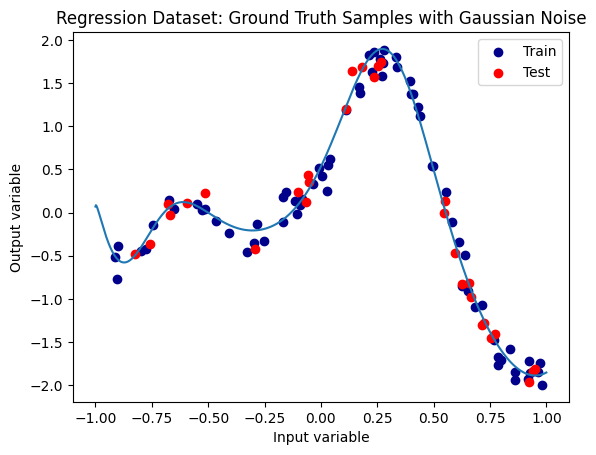

In [181]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=100, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [240]:
BNN = FullCovBNN(1, [4, 4], 1, noise_std=0.15)

In [228]:
update_variational_params_choldate(BNN, x_tr, y_tr, 1, K=1)


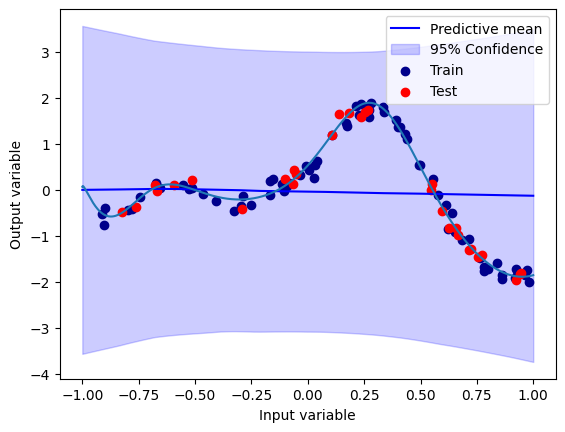

In [241]:
def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array
F
def plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net, n_samples=100):
    n_test = xs.shape[0]
    predictions = np.zeros((n_samples, n_test))

    for i in range(n_samples):
        params_sample = net.sample_network_params()
        predictions[i,] = to_numpy(net.forward(torch.tensor(xs, dtype=torch.float32).unsqueeze(1), params_sample).flatten())

    pred_mean = predictions.mean(0)
    pred_std = predictions.std(0)

    x_tr, x_te = to_numpy(x_tr).flatten(), to_numpy(x_te).flatten()
    y_tr, y_te = to_numpy(y_tr).flatten(), to_numpy(y_te).flatten()

    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
    plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')
    plt.plot(xs, ys)
    plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
    plt.scatter(x_te, y_te, label='Test', color='red')
    plt.xlabel('Input variable')
    plt.ylabel('Output variable')
    plt.legend()
    plt.show()

    
    ############### continue plotting here ###############

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


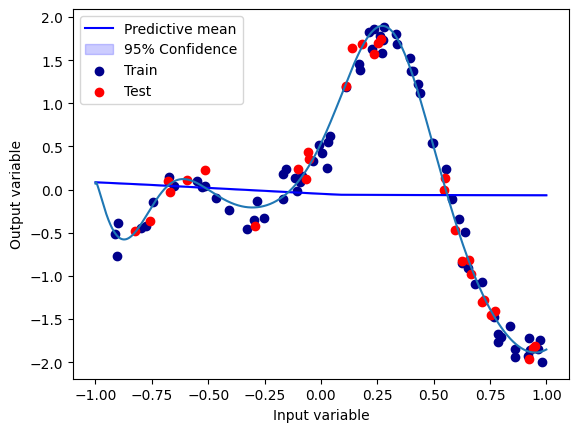

In [251]:
n_epochs = 10
sample_std = 1

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params_choldate(BNN, x_tr, y_tr, sample_std, K=5)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=1)

In [243]:
BNN.network[0].mean

tensor([ 0.0115, -0.0232, -0.0160, -0.0204, -0.0181,  0.0115, -0.0684, -0.0153])

In [245]:
BNN.network[2].mean

tensor([-0.0044,  0.0023, -0.0011, -0.0080, -0.0134, -0.0104,  0.0018, -0.0220,
         0.0045, -0.0015, -0.0337, -0.0028, -0.0141, -0.0111,  0.0365, -0.0194,
        -0.0162, -0.0302, -0.0184,  0.0302])

In [249]:
BNN.network[4].cov_chol@BNN.network[4].cov_chol.t()

tensor([[ 0.0081,  0.0039,  0.0061,  0.0081, -0.0120],
        [ 0.0039,  0.0077,  0.0056,  0.0100, -0.0091],
        [ 0.0061,  0.0056,  0.0161,  0.0116, -0.0160],
        [ 0.0081,  0.0100,  0.0116,  0.0214, -0.0178],
        [-0.0120, -0.0091, -0.0160, -0.0178,  0.0253]])

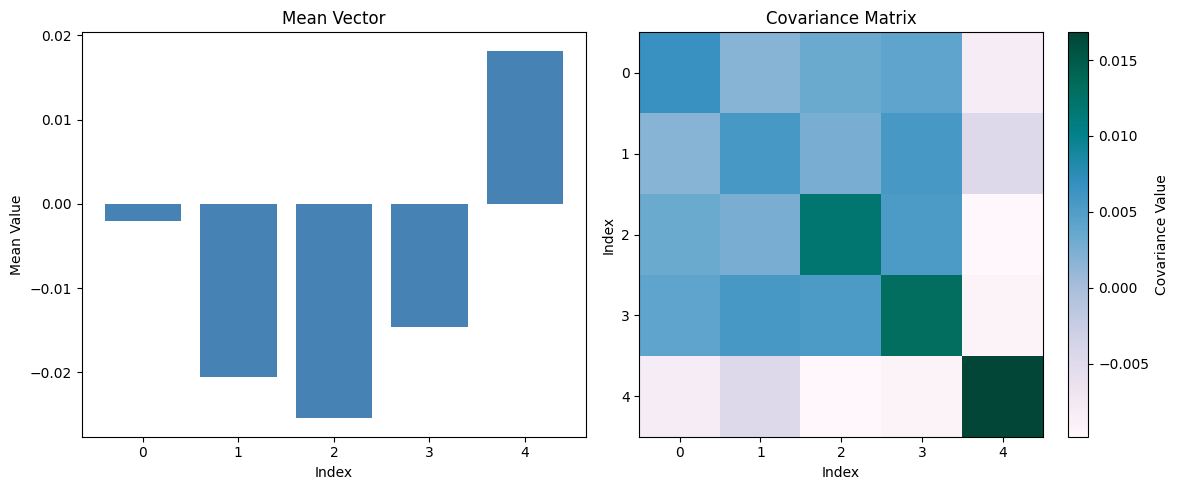

In [252]:
def plot_mean_and_covariance(BNN,layer):
    # Convert mean vector and covariance matrix to NumPy
    mean = to_numpy(BNN.network[layer].mean)
    cov = to_numpy(BNN.network[layer].cov_chol @ BNN.network[layer].cov_chol.t())

    # Create side-by-side subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot mean vector as a bar plot
    axs[0].bar(range(len(mean)), mean, color='steelblue')
    axs[0].set_title("Mean Vector")
    axs[0].set_xlabel("Index")
    axs[0].set_ylabel("Mean Value")

    # Plot covariance matrix as a heatmap
    im = axs[1].imshow(cov, cmap='PuBuGn', aspect='auto')
    axs[1].set_title("Covariance Matrix")
    axs[1].set_xlabel("Index")
    axs[1].set_ylabel("Index")
    fig.colorbar(im, ax=axs[1], label="Covariance Value")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_mean_and_covariance(BNN,4)
